# Import Library dan Dataset

In [1]:
#Import library yang dibutuhkan 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
pd.options.display.max_columns = 50


#import dataset
df_load = pd.read_csv('../input/telco_company.csv')

#Tampilkan jumlah baris dan kolom
print(df_load.shape)

#Tampilkan 5 data teratas
print(df_load.head(5))

#Jumlah ID yang unik
print(df_load.customerID.nunique())

(7113, 22)
   UpdatedAt   customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     202006  45759018157  Female              0     Yes         No     1.0   
1     202006  45557574145    Male              0      No         No    34.0   
2     202006  45366876421    Male              0      No         No     2.0   
3     202006  45779536532    Male              0      No         No    45.0   
4     202006  45923787906  Female              0      No         No     2.0   

  PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0           No  No phone service             DSL             No          Yes   
1          Yes                No             DSL            Yes           No   
2          Yes                No             DSL            Yes          Yes   
3           No  No phone service             DSL            Yes           No   
4          Yes                No     Fiber optic             No           No   

  DeviceProtection TechSupport St

# Mencari Validitas ID Number Pelanggan

**Memfilter ID Number Pelanggan Format Tertentu**

In [2]:
#Membuat kolom bantuan 'valid_id',mencari customerID diawali dengan angka 45 2 digit pertama dengan str.match
df_load['valid_id'] = df_load['customerID'].astype(str).str.match(r'(45\d{9,10})')
#Mengambil valid_id bernilai True kemudian drop kolom valid_id
df_load = (df_load[df_load['valid_id'] == True]).drop('valid_id', axis = 1)
#Menghitung jumlah baris 'customerID' setelah difilter
print('Hasil jumlah ID Customer yang terfilter adalah',df_load['customerID'].count())


Hasil jumlah ID Customer yang terfilter adalah 7006


**Memfilter Duplikasi ID Number Pelanggan**

In [3]:
# Drop Duplicate Rows
df_load.drop_duplicates()
# Drop duplicate ID sorted by Periode
df_load = df_load.sort_values('UpdatedAt', ascending=False).drop_duplicates(['customerID'])
print('Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah 6993


# Mengatasi Missing Values

**Mengatasi Missing Values dengan Penghapusan Rows**

In [4]:
print('Total missing values data dari kolom Churn',df_load['Churn'].isnull().sum())
# Dropping all Rows with spesific column (churn)
df_load.dropna(subset=['Churn'],inplace=True)
print('Total Rows dan kolom Data setelah dihapus data Missing Values adalah',df_load.shape)

Total missing values data dari kolom Churn 43
Total Rows dan kolom Data setelah dihapus data Missing Values adalah (6950, 22)


**Mengatasi Missing Values dengan Pengisian Nilai tertentu**

In [5]:
print('Status Missing Values :',df_load.isnull().values.any())
print('\nJumlah Missing Values masing-masing kolom, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

# handling missing values Tenure fill with 11
df_load['tenure'].fillna(11, inplace=True)

# Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
  median = df_load[col_name].median()
  df_load[col_name].fillna(median, inplace=True)

print('\nJumlah Missing Values setelah di imputer datanya, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

Status Missing Values : True

Jumlah Missing Values masing-masing kolom, adalah:
tenure              99
MonthlyCharges      26
TotalCharges        15
Churn                0
InternetService      0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
UpdatedAt            0
dtype: int64

Jumlah Missing Values setelah di imputer datanya, adalah:
Churn               0
TotalCharges        0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV

# Mengatasi Outlier

**Mendeteksi adanya Outlier (Boxplot)**


Persebaran data sebelum ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.477266       65.783741   2305.083460
std      25.188910       50.457871   2578.651143
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     500.000000     2311.000000  80000.000000


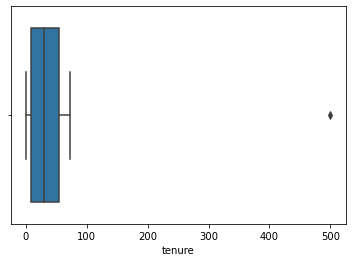

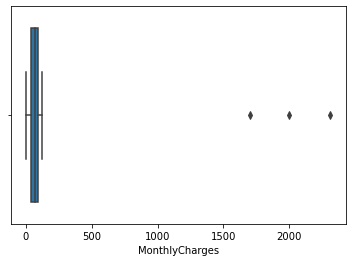

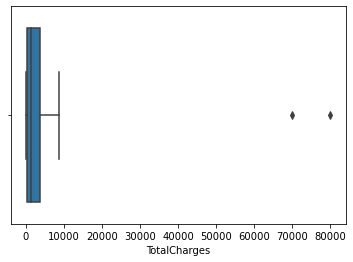

In [6]:
print('\nPersebaran data sebelum ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

# Creating Box Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['tenure'])
plt.show()
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

**Mengatasi Outlier**

In [7]:
# Handling with IQR
Q1 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
print('Nilai Maximum dari masing-masing Variable adalah: ')
print(maximum)
minimum = Q1 - (1.5*IQR)
print('\nNilai Minimum dari masing-masing Variable adalah: ')
print(minimum)

more_than = (df_load > maximum)
lower_than = (df_load < minimum)
df_load = df_load.mask(more_than, maximum, axis=1)
df_load = df_load.mask(lower_than, minimum, axis=1)

print('\nPersebaran data setelah ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

Nilai Maximum dari masing-masing Variable adalah: 
tenure             124.00000
MonthlyCharges     169.93125
TotalCharges      8889.13125
dtype: float64

Nilai Minimum dari masing-masing Variable adalah: 
tenure             -60.00000
MonthlyCharges     -43.61875
TotalCharges     -4682.31875
dtype: float64

Persebaran data setelah ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.423165       64.992201   2286.058750
std      24.581073       30.032040   2265.702553
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     124.000000      169.931250   8889.131250


# Menstandarisasi Nilai

**Mendeteksi Nilai yang tidak Standar**

In [8]:
#Loop
for col_name in list(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']):
  print('\nUnique Values Count \033[1m' + 'Before Standardized \033[0m Variable',col_name)

  print(df_load[col_name].value_counts())


Unique Values Count Before Standardized  Variable gender
Male         3499
Female       3431
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Unique Values Count Before Standardized  Variable SeniorCitizen
0    5822
1    1128
Name: SeniorCitizen, dtype: int64

Unique Values Count Before Standardized  Variable Partner
No     3591
Yes    3359
Name: Partner, dtype: int64

Unique Values Count Before Standardized  Variable Dependents
No     4870
Yes    2060
Iya      20
Name: Dependents, dtype: int64

Unique Values Count Before Standardized  Variable PhoneService
Yes    6281
No      669
Name: PhoneService, dtype: int64

Unique Values Count Before Standardized  Variable MultipleLines
No                  3346
Yes                 2935
No phone service     669
Name: MultipleLines, dtype: int64

Unique Values Count Before Standardized  Variable InternetService
Fiber optic    3057
DSL            2388
No             1505
Name: InternetService, dtype: int64

Unique Values Count Befor

**Menstandarisasi Variable Kategorik**

In [9]:
#Replace unique values dari masing-masing variable
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])

#Memihat unique values setelah dilakukan standarisasi
for col_name in list(['gender','Dependents','Churn']):
  print('\nUnique Values Count \033[1m' + 'After Standardized \033[0mVariable',col_name)
  print(df_load[col_name].value_counts())


Unique Values Count After Standardized Variable gender
Male      3505
Female    3445
Name: gender, dtype: int64

Unique Values Count After Standardized Variable Dependents
No     4870
Yes    2080
Name: Dependents, dtype: int64

Unique Values Count After Standardized Variable Churn
No     5114
Yes    1836
Name: Churn, dtype: int64


In [10]:
#Mengambil kolom yang diperlukan yang disimpan pada variabel df_telco
df_telco = df_load[['UpdatedAt','customerID', 'gender','SeniorCitizen','Partner','tenure','PhoneService','StreamingTV','InternetService','PaperlessBilling','MonthlyCharges','TotalCharges','Churn']]

#Tampilkan bentuk dari dataset
print(df_telco.shape)

#Tampilkan 5 data teratas
print(df_telco.head())

#Tampilkan jumlah ID yang unik
print(df_telco.customerID.nunique())

(6950, 13)
      UpdatedAt   customerID  gender  SeniorCitizen Partner  tenure  \
0        202006  45759018157  Female              0     Yes     1.0   
4727     202006  45315483266    Male              0     Yes    60.0   
4738     202006  45236961615    Male              0      No     5.0   
4737     202006  45929827382  Female              0     Yes    72.0   
4736     202006  45305082233  Female              0     Yes    56.0   

     PhoneService          StreamingTV InternetService PaperlessBilling  \
0              No                   No             DSL              Yes   
4727          Yes  No internet service              No              Yes   
4738          Yes                  Yes     Fiber optic               No   
4737          Yes                  Yes     Fiber optic              Yes   
4736          Yes                  Yes             DSL               No   

      MonthlyCharges  TotalCharges Churn  
0              29.85         29.85    No  
4727           20.50     

# Melakukan Exploratory Data Analysis (EDA)

**Memvisualisasikan Prosentase Churn**

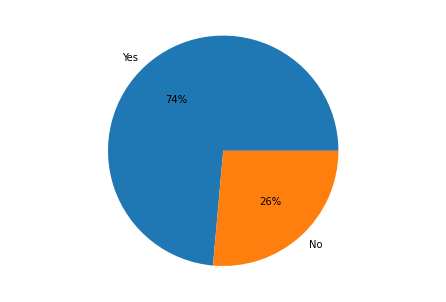

In [11]:
#Membuat figur plot
fig = plt.figure()
#Membuat sumbu plot
ax = fig.add_axes([0,0,1,1])
#Mengubah batas sumbu x atau y sehingga memiliki panjang yang sama
ax.axis('equal')
#Membuat Label pie chart
labels = ['Yes','No']
#Menghitung banyaknya unik dari kolom Churn dengan value_counts()
churn = df_telco.Churn.value_counts()
#Membuat bentuk pie chart
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.show()

**Exploratory Data Analysis (EDA) Variabel Numerik**

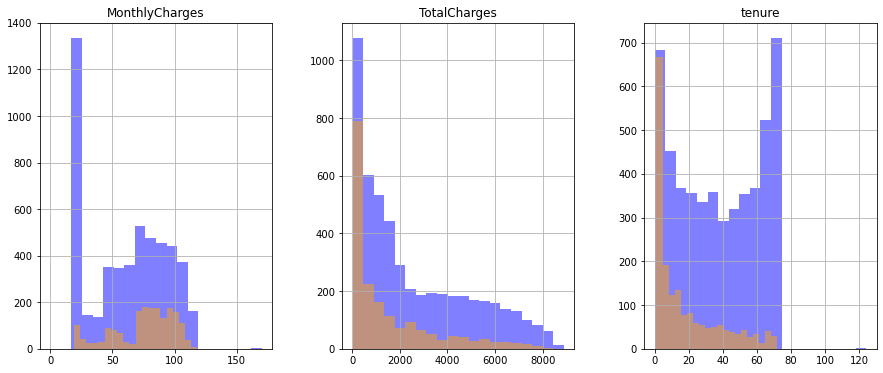

In [12]:
#Membuat bin dalam chart
numerical_features =  ['MonthlyCharges','TotalCharges','tenure']
#Membuat subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
#Untuk memplot dua overlay histogram per numerical_features masing-masing
df_load[df_telco.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_telco.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

**Exploratory Data Analysis (EDA) Variabel Kategorik**

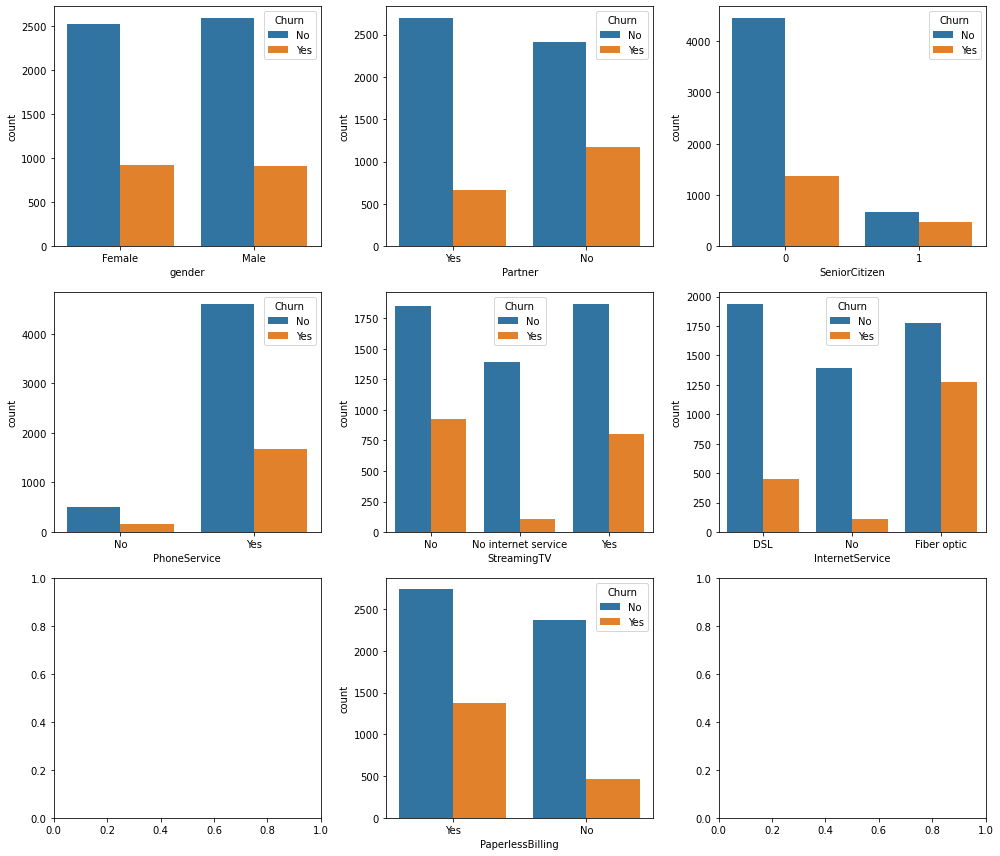

In [13]:
#Membuat subplot
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
#membuat plot dengan jumlah pengamatan di setiap bin kategorik variable dengan countplot()
sns.countplot(data=df_telco, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_telco, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_telco, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_telco, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_telco, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_telco, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_telco, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()


# Melakukan Data PreProcessing

**Menghapus Unnecessary Columns dari data**

In [14]:
#Menghapus kolom customerID & UpdatedAt
cleaned_df = df_telco.drop(['customerID','UpdatedAt'], axis=1)
print(cleaned_df.head())

      gender  SeniorCitizen Partner  tenure PhoneService          StreamingTV  \
0     Female              0     Yes     1.0           No                   No   
4727    Male              0     Yes    60.0          Yes  No internet service   
4738    Male              0      No     5.0          Yes                  Yes   
4737  Female              0     Yes    72.0          Yes                  Yes   
4736  Female              0     Yes    56.0          Yes                  Yes   

     InternetService PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0                DSL              Yes           29.85         29.85    No  
4727              No              Yes           20.50       1198.80    No  
4738     Fiber optic               No          104.10        541.90   Yes  
4737     Fiber optic              Yes          115.50       8312.75    No  
4736             DSL               No           81.25       4620.40    No  


**Encoding Data**

In [15]:
#Mengubah semua tipe data non-numeric columns ke numerical
for column in cleaned_df.columns:
    if cleaned_df[column].dtype == np.number: continue
    #Melakukan encoding  untuk setiap kolom non-numeric dengan LabelEncoder()
    cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner       tenure  PhoneService  \
count  6950.000000    6950.000000  6950.000000  6950.000000   6950.000000   
mean      0.504317       0.162302     0.483309    32.423165      0.903741   
std       0.500017       0.368754     0.499757    24.581073      0.294967   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     9.000000      1.000000   
50%       1.000000       0.000000     0.000000    29.000000      1.000000   
75%       1.000000       0.000000     1.000000    55.000000      1.000000   
max       1.000000       1.000000     1.000000   124.000000      1.000000   

       StreamingTV  InternetService  PaperlessBilling  MonthlyCharges  \
count  6950.000000      6950.000000       6950.000000     6950.000000   
mean      0.985180         0.872950          0.591942       64.992201   
std       0.885069         0.737618          0.491509       30.032040   
min       0.00

**Splitting Dataset**

In [16]:
# Predictor dan target
X = cleaned_df.drop('Churn', axis = 1)
y = cleaned_df['Churn']
# Splitting train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Jumlah baris dan kolom dari x_train adalah:', x_train.shape,', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Prosentase Churn di data Training adalah:')
#Mengecek apakah pembagian sudah sama proporsinya
print(y_train.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah: (4865, 10) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Prosentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64


# Modelling: Logistic Regression

**Pembuatan Model**

In [17]:
#Membuat model dengan menggunakan Algoritma Logistic Regression
log_model = LogisticRegression().fit(x_train, y_train)
print('Model Logistic Regression yang terbentuk adalah: \n',log_model)

Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression()


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Performansi Model Training - Menampilkan Metrics**

In [18]:
# Predict
y_train_pred =  log_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3575
           1       0.65      0.49      0.56      1290

    accuracy                           0.79      4865
   macro avg       0.74      0.70      0.71      4865
weighted avg       0.78      0.79      0.78      4865



**Performansi Model Training - Menampilkan Plots**

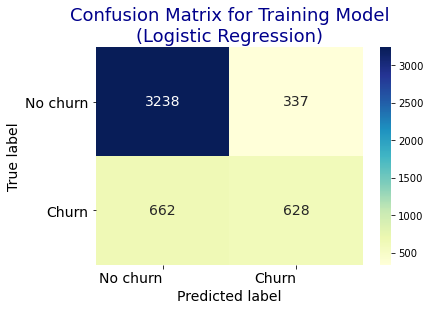

In [19]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

**Performansi Data Testing - Menampilkan Metrics**

In [20]:
# Predict
y_test_pred = log_model.predict(x_test)
# Print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



**Performansi Data Testing - Menampilkan Plots**

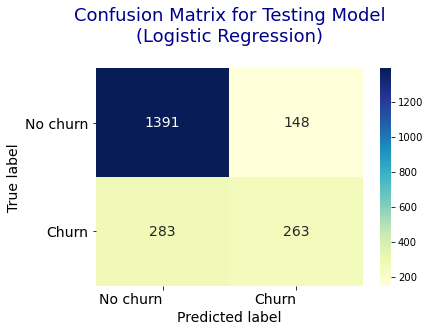

In [21]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [22]:
#Save Model
pickle.dump(log_model, open('best_model_churn.pkl', 'wb'))